<a href="https://colab.research.google.com/github/maximmillion/ConvolutionExp/blob/main/transfer_learning_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import History 

from random import randint
import numpy as np3

import matplotlib.pyplot as plt

from skimage.filters import gaussian
from skimage.util import random_noise
import matplotlib.pyplot as pp

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

from tensorflow.keras import datasets, layers, models
from xgboost import XGBClassifier
%matplotlib inline

# Making the dataset:

In [26]:
# Create 250 squares
NUM_SQUARES = 250
WIDTH = 128

X_train = []
for i in range(NUM_SQUARES):
    exp = np.zeros((WIDTH, WIDTH)) #  128*128 canvas 
    x_start = randint(0, WIDTH - 1)
    x_end = randint(x_start, WIDTH)
    y_start = randint(0, WIDTH - 1)
    y_end = randint(y_start, WIDTH)
    for x in range(y_start, y_end):
        for y in range(y_start, y_end):
            exp[x, y] = 1
    X_train.append(exp)

In [27]:
# Create 250 circles
for i in range(NUM_SQUARES):
    x = np.arange(0, WIDTH)
    y = np.arange(0, WIDTH)
    arr = np.zeros((y.size, x.size))

    cx = randint(0, WIDTH)
    cy = randint(0, WIDTH)
    r = randint(0, WIDTH / 2)

    # The two lines below could be merged, but I stored the mask
    # for code clarity.
    mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < r**2
    arr[mask] = 1
    if randint(0, 1) == 0: # sometie true
        arr = np.fliplr(arr)
    X_train.append(arr)
print(len(X_train))

500


In [28]:
Y_train = np.array([1 if i < NUM_SQUARES else 0 for i in range(NUM_SQUARES * 2)])

In [29]:
# Shuffle training data
shuffler = np.random.permutation(NUM_SQUARES*2)

X_train = np.array(X_train)

shufled_X_train = X_train[shuffler]
shufled_Y_train = Y_train[shuffler]

0


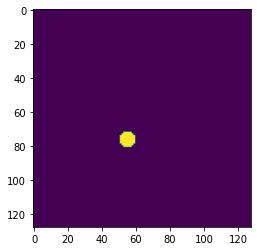

In [30]:
print(shufled_Y_train[100])
plt.imshow(shufled_X_train[100])

In [39]:
# 85% is training data, 15% will never be seen by the models
NUM_TRAIN = int(NUM_SQUARES*2*0.85)

X_train = shufled_X_train[ : NUM_TRAIN]
Y_train = shufled_Y_train[ : NUM_TRAIN] 

X_test = shufled_X_train[NUM_TRAIN : ]
Y_test = shufled_Y_train[NUM_TRAIN:] 

# Model Work: 

In [32]:
from keras.applications.vgg16 import VGG16

In [33]:
img_input = layers.Input(shape=(WIDTH, WIDTH, 1)) 

# Adding some extra layers before the input to deal with a single channel image
# We duplicate image 3 times to make it 3 channels, since vgg takes a 3 channel input
img_conc = layers.Concatenate()([img_input, img_input, img_input]) 

# Load model without classifier/fully connected layers
# The top 3 layers are the fully connected dense layers, but when we say include_top = False
# it means we don't want them, we only want the Convolutional layers
VGG_model = VGG16(input_tensor=img_conc, weights='imagenet', include_top=False)

In [34]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False

In [35]:
# Summary of feature extractor model
VGG_model.summary()  #Trainable parameters will be 0 (we are not learning, it is already 'perfect')

Model: "vgg16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 128, 128, 3)  0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['concatenate_1[0][0]']      

## Using the model:

In [36]:
# Adding the extra dimension as required by the model
X_wanted_train = X_train.reshape(len(X_train), WIDTH, WIDTH, 1)
X_wanted_test = X_test.reshape(len(X_test), WIDTH, WIDTH, 1)

In [40]:
#TRAINING DATA

# Now, let us get the features from the Convolutional network of the vgg 
feature_extractor = VGG_model.predict(X_wanted_train)

# We reshape output into 1D array so we can use for models
features_train = feature_extractor.reshape(feature_extractor.shape[0], -1)
features_train.shape

(425, 8192)

In [41]:
#TESTING DATA

# Now, let us get the features from the Convolutional network of the vgg
feature_extractor = VGG_model.predict(X_wanted_test)

# We reshape output into 1D array so we can use for models
features_test = feature_extractor.reshape(feature_extractor.shape[0], -1)
features_train.shape

# Applying classical models on the features:

## Decision tree:

In [15]:
results = {}

In [16]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(features_train, Y_train)

# Predict the response for test dataset
y_pred = clf.predict(features_test)

accuracy = accuracy_score(Y_test, y_pred)
results['decision_tree'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(Y_test, y_pred))

Accuracy: 0.9466666666666667

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        42
           1       0.91      0.97      0.94        33

    accuracy                           0.95        75
   macro avg       0.94      0.95      0.95        75
weighted avg       0.95      0.95      0.95        75



[Text(0.5416666666666666, 0.9285714285714286, 'X[2818] <= 0.013\ngini = 0.5\nsamples = 425\nvalue = [208, 217]'),
 Text(0.4583333333333333, 0.7857142857142857, 'X[2814] <= 0.983\ngini = 0.267\nsamples = 258\nvalue = [41, 217]'),
 Text(0.25, 0.6428571428571429, 'X[5108] <= 0.623\ngini = 0.127\nsamples = 220\nvalue = [15, 205]'),
 Text(0.16666666666666666, 0.5, 'X[5118] <= 0.68\ngini = 0.064\nsamples = 212\nvalue = [7, 205]'),
 Text(0.08333333333333333, 0.35714285714285715, 'gini = 0.0\nsamples = 192\nvalue = [0, 192]'),
 Text(0.25, 0.35714285714285715, 'X[7285] <= 0.646\ngini = 0.455\nsamples = 20\nvalue = [7, 13]'),
 Text(0.16666666666666666, 0.21428571428571427, 'X[7130] <= 0.397\ngini = 0.401\nsamples = 18\nvalue = [5, 13]'),
 Text(0.08333333333333333, 0.07142857142857142, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.25, 0.07142857142857142, 'gini = 0.444\nsamples = 15\nvalue = [5, 10]'),
 Text(0.3333333333333333, 0.21428571428571427, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]')

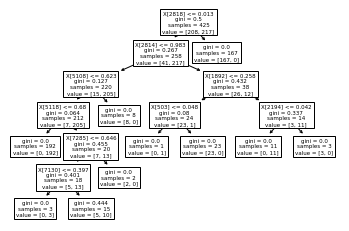

In [17]:
# plot tree
from sklearn import tree

tree.plot_tree(clf)

## Random Forest:

In [18]:
# Create Random Forest classifer object
clf = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train Decision Tree Classifer
clf = clf.fit(features_train, Y_train)

# Predict the response for test dataset
y_pred = clf.predict(features_test)

accuracy = accuracy_score(Y_test, y_pred)
results['random_forest'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(Y_test, y_pred))

Accuracy: 0.96

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.94      0.97      0.96        33

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



### Increasing Estimators:

In [19]:
# Create Random Forest classifer object
clf = RandomForestClassifier(n_estimators = 100, random_state = 42)

# Train Decision Tree Classifer
clf = clf.fit(features_train, Y_train)

# Predict the response for test dataset
y_pred = clf.predict(features_test)

accuracy = accuracy_score(Y_test, y_pred)
results['random_forest_100'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(Y_test, y_pred))

Accuracy: 0.9733333333333334

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.94      1.00      0.97        33

    accuracy                           0.97        75
   macro avg       0.97      0.98      0.97        75
weighted avg       0.97      0.97      0.97        75



## Adaboost Classifier:

In [20]:
# Create Adaboostclassifier
clf = AdaBoostClassifier(n_estimators=42)

# Train Decision Tree Classifer
clf = clf.fit(features_train, Y_train)

# Predict the response for test dataset
y_pred = clf.predict(features_test)

accuracy = accuracy_score(Y_test, y_pred)
results['adaboost'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(Y_test, y_pred))

Accuracy: 0.9733333333333334

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.94      1.00      0.97        33

    accuracy                           0.97        75
   macro avg       0.97      0.98      0.97        75
weighted avg       0.97      0.97      0.97        75



## XG Boost Classifier:

In [21]:
# Create XG boost classifer object
clf = XGBClassifier()

# Train Decision Tree Classifer
clf = clf.fit(features_train, Y_train)

# Predict the response for test dataset
y_pred = clf.predict(features_test)

accuracy = accuracy_score(Y_test, y_pred)
results['xgboost'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(Y_test, y_pred))

Accuracy: 0.9733333333333334

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.94      1.00      0.97        33

    accuracy                           0.97        75
   macro avg       0.97      0.98      0.97        75
weighted avg       0.97      0.97      0.97        75



## Gaussian Naive Bayes:

In [22]:
from sklearn.naive_bayes import GaussianNB

# Create Gaussian Naive Bayes Classifier
clf = GaussianNB()

# Train Decision Tree Classifer
clf = clf.fit(features_train, Y_train)

# Predict the response for test dataset
y_pred = clf.predict(features_test)

accuracy = accuracy_score(Y_test, y_pred)
results['gaussianNB'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(Y_test, y_pred))

Accuracy: 0.9733333333333334

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.97      0.97      0.97        33

    accuracy                           0.97        75
   macro avg       0.97      0.97      0.97        75
weighted avg       0.97      0.97      0.97        75



## Logistic Regression:

In [23]:
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression Classifier
clf = LogisticRegression(solver='liblinear')

# Train Decision Tree Classifer
clf = clf.fit(features_train, Y_train)

# Predict the response for test dataset
y_pred = clf.predict(features_test)

accuracy = accuracy_score(Y_test, y_pred)
results['logistic'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(Y_test, y_pred))

Accuracy: 0.96

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.94      0.97      0.96        33

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



# Plotting the results:

<BarContainer object of 7 artists>

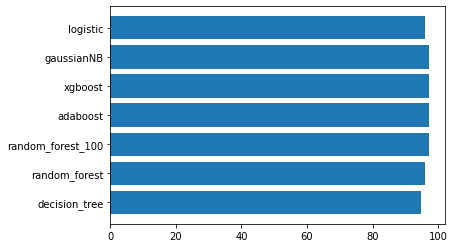

In [24]:
plt.barh(list(results.keys()), results.values())